# Topic Modelling

In this project we will explore various methods of finding topics and subtopics in a corpus of tweets.

In [199]:
#Importing requisite libraries
import pandas as pd
import numpy as np
import re
import os
import glob
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans
from sklearn.preprocessing import scale
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
import os.path
from gensim import corpora
from gensim.models import LsiModel
from nltk.tokenize import RegexpTokenizer
from gensim.models.coherencemodel import CoherenceModel
from sklearn.decomposition import TruncatedSVD
from gensim.models import KeyedVectors

In [140]:
!sudo pip3 install -t /home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages gensim

    100% |████████████████████████████████| 24.2MB 1.8MB/s eta 0:00:01
    100% |████████████████████████████████| 20.4MB 2.4MB/s eta 0:00:01
  Using cached https://files.pythonhosted.org/packages/73/fb/00a976f728d0d1fecfe898238ce23f502a721c0ac0ecfedb80e0d88c64e9/six-1.12.0-py2.py3-none-any.whl
    100% |████████████████████████████████| 25.2MB 2.0MB/s eta 0:00:01    42% |█████████████▊                  | 10.8MB 62.9MB/s eta 0:00:01
    100% |████████████████████████████████| 71kB 36.3MB/s ta 0:00:01
  Using cached https://files.pythonhosted.org/packages/23/10/c0b78c27298029e4454a472a1919bde20cb182dab1662cec7f2ca1dcc523/boto-2.49.0-py2.py3-none-any.whl
    100% |████████████████████████████████| 61kB 31.2MB/s ta 0:00:01
    100% |████████████████████████████████| 133kB 42.1MB/s ta 0:00:01
    100% |████████████████████████████████| 61kB 33.1MB/s ta 0:00:01
  Using cached https://files.pythonhosted.org/packages/bc/a9/01ffebfb562e4274b6487b4bb1ddec7ca55ec7510b22e4c51f14098443b8/chardet-3

In [44]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

# Data Extraction

Data from multiple files is combined and everything apart from tweet itsef(like id,timestamp) are remove.

In [170]:
file_paths = os.getcwd() + "/Health-Tweets/*.txt"
content_total = []
for f_path in glob.glob(file_paths):
    with open(file_path) as f:
        content_list = f.readlines()
    content_total.append(content_list)
content_flat = []
for sublist in content_total:
    for val in sublist:
        content_flat.append(val)
content_list_clean = []
for ele in content_flat:
    content_list_clean.append(ele.split("|")[-1])
print(content_list_clean[:5])
print("-"*50)
print("Total dataset size: {}".format(len(content_list_clean)))


['Breast cancer risk test devised http://bbc.in/1CimpJF\n', 'GP workload harming care - BMA poll http://bbc.in/1ChTBRv\n', "Short people's 'heart risk greater' http://bbc.in/1ChTANp\n", "New approach against HIV 'promising' http://bbc.in/1E6jAjt\n", "Coalition 'undermined NHS' - doctors http://bbc.in/1CnLwK7\n"]
--------------------------------------------------
Total dataset size: 62864


In [171]:
#Function to expand words
def decontracter(text):
    # specific
    text = re.sub(r"won't", "will not", text)
    text = re.sub(r"can\'t", "can not", text)

    # general
    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'s", " is", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'m", " am", text)
    return text

In [172]:
#Remove url from the text
def url_remover(text):
    text = re.sub(r'http\S+', '', text)#https://stackoverflow.com/questions/11331982/how-to-remove-any-url-within-a-string-in-python
    return text

In [29]:
#remove escape character at the end of every tweet
def escape_remover(text):
    text = re.sub("\\n","",text)
    return text

In [35]:
#remove anything which is not an alphabet
def spc_remover(text): #https://stackoverflow.com/questions/5843518/remove-all-special-characters-punctuation-and-spaces-from-string
    text = re.sub('[^A-Za-z]+', '', text)
    return text

In [60]:
stop_words = stopwords.words('english')
print(stop_words)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

# Data Cleaning

Applying all the text cleaning operations including stemming.Stopwords will be removed in the word vectorization step.

In [61]:
#https://machinelearningmastery.com/clean-text-machine-learning-python/
content_processed = []
for text in content_list_clean:
    text = decontracter(text)
    text = url_remover(text)
    text = escape_remover(text)
    text = text.lower()
    word_list = text.split()
    text = [spc_remover(word) for word in word_list]
    text = " ".join(text)
    tokens = word_tokenize(text)
    words = [word for word in tokens if word.isalpha()]
    porter = PorterStemmer()
    stemmed = [porter.stem(word) for word in words]
    text = " ".join(stemmed)
    content_processed.append(text)


In [62]:
df = pd.DataFrame({"original_tweet":content_list_clean,
                   "cleaned_tweet":content_processed})
df.head()

,original_tweet,cleaned_tweet
0,Breast cancer risk test devised http://bbc.in/...,breast cancer risk test devis
1,GP workload harming care - BMA poll http://bbc...,gp workload harm care bma poll
2,Short people's 'heart risk greater' http://bbc...,short peopl is heart risk greater
3,New approach against HIV 'promising' http://bb...,new approach against hiv promis
4,Coalition 'undermined NHS' - doctors http://bb...,coalit undermin nh doctor


# Count Vectorizer + Kmeans Clustering

In this section we have explored Kmeans clustering by count vectorizing the tweets. It is observed that same kinds of words are appearing in multiple documents and we need a method to remove words that occur frequently in all the documents. These words do not provide any useful information. Also while, exploring different values of k, knee shaped curve is not observed which makes it difficult to identify the exact number of clusters.

In [66]:
vectorizer = CountVectorizer()
tweet_matrix = vectorizer.fit_transform(df['cleaned_tweet'])

In [70]:
number_of_clusters=10 #Randomly experimenting with 10 Clusters
km = KMeans(n_clusters=number_of_clusters)
km.fit(tweet_matrix)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=10, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [71]:
print("Top terms per cluster:")
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()
for i in range(number_of_clusters):
    top_ten_words = [terms[ind] for ind in order_centroids[i, :5]]
    print("Cluster {}: {}".format(i, ' '.join(top_ten_words)))

Top terms per cluster:
Cluster 0: ebola video to uk for
Cluster 1: for video call care is
Cluster 2: heart surgeri is risk attack
Cluster 3: over warn video death concern
Cluster 4: is cancer audio hospit health
Cluster 5: video in is on health
Cluster 6: in ebola the rise care
Cluster 7: of the video risk is
Cluster 8: nh to video the on
Cluster 9: to video link hospit be


In [74]:
df['category'] = km.labels_

In [76]:
df.sort_values(by='category',inplace=True)
df.head()

,original_tweet,cleaned_tweet,category
28835,VIDEO: Ebola: 'Europe will see more cases' htt...,video ebola europ will see more case,0
56748,Ebola drug given to US aid workers http://bbc....,ebola drug given to us aid worker,0
20197,Possible Ebola case flown to UK http://bbc.in/...,possibl ebola case flown to uk,0
47961,VIDEO: WHO: 'Ebola running ahead of us' http:/...,video who ebola run ahead of us,0
56751,VIDEO: World Bank launches Ebola fund http://b...,video world bank launch ebola fund,0


In [77]:
df[df['category']==1].head()

,original_tweet,cleaned_tweet,category
15575,Nike and the battle for your wrist http://bbc....,nike and the battl for your wrist,1
49834,Call for change to breast screening http://bbc...,call for chang to breast screen,1
39079,Coffee v smoothies: Which is better for you? h...,coffe v smoothi which is better for you,1
31770,Breath test for Parkinson's disease http://bbc...,breath test for parkinson is diseas,1
31782,'Smart' insulin hope for diabetes http://bbc.i...,smart insulin hope for diabet,1


In [78]:
df[df['category']==2].head()

,original_tweet,cleaned_tweet,category
46566,Hospital liver surgery is defended http://bbc....,hospit liver surgeri is defend,2
9960,Patient sings through throat surgery http://bb...,patient sing through throat surgeri,2
42719,Energy drinks 'change heart beat' http://bbc.i...,energi drink chang heart beat,2
2784,Women get heart disease too http://bbc.in/1nyc...,women get heart diseas too,2
2294,Stressful films 'endanger the heart' http://bb...,stress film endang the heart,2


In [79]:
df[df['category']==3].head()

,original_tweet,cleaned_tweet,category
62826,Muslim concern over flu vaccine http://bbc.in/...,muslim concern over flu vaccin,3
14355,Hospital admits failings over death http://bbc...,hospit admit fail over death,3
46371,'Stay away' plea over ward bug cases http://bb...,stay away plea over ward bug case,3
11663,Over-50s osteoporosis scale revealed http://bb...,over osteoporosi scale reveal,3
11659,Ops postponed over staff shortages http://bbc....,op postpon over staff shortag,3


In [80]:
df[df['category']==4].head()

,original_tweet,cleaned_tweet,category
38940,"Target MMR at teenagers, report says http://bb...",target mmr at teenag report say,4
26289,Foetuses were 'kept' at hospital http://bbc.in...,foetus were kept at hospit,4
36853,Rugby players 'risk skin infections' http://bb...,rugbi player risk skin infect,4
36854,Ashya proton beam sessions begin http://bbc.in...,ashya proton beam session begin,4
38155,Sixteen killed by hospital superbug http://bbc...,sixteen kill by hospit superbug,4


In [83]:
inertia_list = []
for k in range (1, 21):
    km = KMeans(n_clusters=k, random_state=1).fit(tweet_matrix)
    labels = km.labels_
    inertia = km.inertia_
    inertia_list.append(inertia)
    print("k:",k, " cost:", inertia)

k: 1  cost: 352403.7994400577
k: 2  cost: 341825.22711696196
k: 3  cost: 337103.77942387137
k: 4  cost: 330404.38651026424
k: 5  cost: 329499.10027300863
k: 6  cost: 323416.9490112806
k: 7  cost: 321507.5150265561
k: 8  cost: 318587.4627848241
k: 9  cost: 318526.23280329694
k: 10  cost: 316054.4585823744
k: 11  cost: 314178.09299857105
k: 12  cost: 312381.02707473666
k: 13  cost: 311937.49894902756
k: 14  cost: 309865.57968569914
k: 15  cost: 308465.27877053065
k: 16  cost: 306409.6964119803
k: 17  cost: 306573.34808141395
k: 18  cost: 306898.1887490723
k: 19  cost: 304539.591326707
k: 20  cost: 302199.8867646917


In [96]:
inertia_list = [round(val,0) for val in inertia_list]

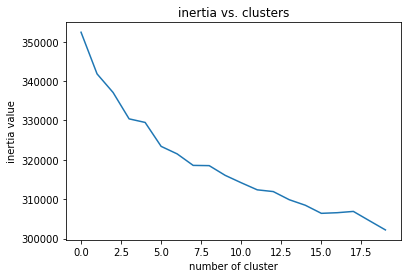

In [91]:
plt.plot(inertia_list)
plt.ylabel("inertia value")
plt.xlabel("number of cluster")
plt.title("inertia vs. clusters")
plt.show()

# TF-IDF Vectorizer + Kmeans Clustering

To tackle the problems of Count Vectorizer,we'll shift to Tf-Idf vectorizer.Stopwords are going to be removed alongwith words present in more that 80% of the documents using *max_df* parameter of TfIdvectorizer. Overall,Tf-Idf will increase that impact of that are highly frequent in some documents but less frequent overall among all the documents.The default implementation of Kmeans has eucleadean distance as a similarity measure. Since we are dealing with over 14000 dimensions, there is a good chance curse of dimensionality is not letting us separate the clusters very well. If time permits,we'll do a custom implemtation of Kmeans that uses consine similarity as a distance measure.

In [97]:
stop_words_set = set(stop_words)
stop_words_set.update(['video','audio']) #These words are very frequent among the tweets and are hence,included in stopwords set

In [99]:
tf_idf_vectorizer = TfidfVectorizer(stop_words=stop_words_set,ngram_range=(1,2),max_df=.8)
tf_idf_tweet_matrix = tf_idf_vectorizer.fit_transform(df['cleaned_tweet'])

In [100]:
tf_idf_tweet_matrix.shape

(62864, 14453)

In [101]:
number_of_clusters=10 #Randomly exploring k=10
km = KMeans(n_clusters=number_of_clusters)
km.fit(tf_idf_tweet_matrix)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=10, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [103]:
print("Top terms per cluster:")
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
terms = tf_idf_vectorizer.get_feature_names()
for i in range(number_of_clusters):
    top_ten_words = [terms[ind] for ind in order_centroids[i, :5]]
    print("Cluster {}: {}".format(i, ' '.join(top_ten_words)))

Top terms per cluster:
Cluster 0: hospit care death babi call
Cluster 1: health mental health mental health servic child mental
Cluster 2: aamp wait aamp wait target wait time
Cluster 3: cancer drug breast cancer breast cancer drug
Cluster 4: patient ebola patient patient death cancer patient hospit
Cluster 5: life whi may may face end
Cluster 6: doctor ban smoke car smoke ban
Cluster 7: nh nh staff staff strike plan
Cluster 8: gp surgeri see see gp gp practic
Cluster 9: ebola uk vaccin ebola vaccin ebola case


## Observation

Words at the center of every cluster are very different from each other, so 10 might be the appropriate number of clusters.

In [104]:
df['category_tf_idf'] = km.labels_

In [105]:
df.sort_values(by='category_tf_idf',inplace=True)
df.head()

,original_tweet,cleaned_tweet,category,category_tf_idf
114,'Selfie danger' during solar eclipse http://bb...,selfi danger dure solar eclips,4,0
21676,Right-to-die court judgement due http://bbc.in...,righttodi court judgement due,4,0
22902,'Our son's 12-hour brain tumour op' http://bbc...,our son is hour brain tumour op,4,0
20663,Drowning: 'Hidden childhood killer' http://bbc...,drown hidden childhood killer,4,0
22901,Children's hospital 'must get clean' http://bb...,children is hospit amust get clean,4,0


In [106]:
df[df['category_tf_idf']==0].head()

,original_tweet,cleaned_tweet,category,category_tf_idf
114,'Selfie danger' during solar eclipse http://bb...,selfi danger dure solar eclips,4,0
21676,Right-to-die court judgement due http://bbc.in...,righttodi court judgement due,4,0
22902,'Our son's 12-hour brain tumour op' http://bbc...,our son is hour brain tumour op,4,0
20663,Drowning: 'Hidden childhood killer' http://bbc...,drown hidden childhood killer,4,0
22901,Children's hospital 'must get clean' http://bb...,children is hospit amust get clean,4,0


In [107]:
df[df['category_tf_idf']==1].head()

,original_tweet,cleaned_tweet,category,category_tf_idf
56729,Clegg: Mental health 'needs boost' http://bbc....,clegg mental health need boost,4,1
8263,Mental health services 'inadequate' http://bbc...,mental health servic inadequ,4,1
12108,Could smart phones help provide mental health ...,could smart phone help provid mental health care,4,1
8897,Exotic pets and the risks to health http://bbc...,exot pet and the risk to health,9,1
19519,Air pollution 'still harming health' http://bb...,air pollut istil harm health,4,1


In [108]:
df[df['category_tf_idf']==2].head()

,original_tweet,cleaned_tweet,category,category_tf_idf
20177,VIDEO: Could volunteers help A&amp;E crisis? h...,video could volunt help aamp crisi,5,2
59255,A&amp;E waits improve across England http://bb...,aamp wait improv across england,4,2
3569,VIDEO: NHS shake-up proposes two-tier A&amp;E ...,video nh shakeup propos twotier aamp,8,2
20437,VIDEO: Burnham: Worst week on record in A&amp;...,video burnham worst week on record in aamp,5,2
11119,Two A&amp;E units' opening hours reduced http:...,two aamp unit open hour reduc,4,2


In [109]:
df[df['category_tf_idf']==3].head()

,original_tweet,cleaned_tweet,category,category_tf_idf
16846,Some ethnic groups 'less cancer aware' http://...,some ethnic group less cancer awar,4,3
23031,Middle-aged drink and drugs warning http://bbc...,middleag drink and drug warn,4,3
55610,How do we pay for innovative drugs? http://bbc...,how do we pay for innov drug,1,3
401,'Half of UK people' will get cancer http://bbc...,half of uk peopl will get cancer,7,3
33674,Refugees 'struggle for cancer care' http://bbc...,refuge istruggl for cancer care,1,3


In [110]:
df[df['category_tf_idf']==5].head()

,original_tweet,cleaned_tweet,category,category_tf_idf
40790,Brains may 'resist Alzheimer's' http://bbc.in/...,brain may aresist alzheim is,4,5
62709,Why I write my Down's dad blog http://bbc.in/1...,whi i write my down is dad blog,4,5
49919,Faulty implants end women's sex life http://bb...,faulti implant end women is sex life,4,5
19265,Bleach may 'heal skin diseases' http://bbc.in/...,bleach may heal skin diseas,4,5
8950,Inherited bugs may help weight loss http://bbc...,inherit bug may help weight loss,4,5


In [111]:
inertia_list_tf_idf = []
for k in range (1, 21):
    km = KMeans(n_clusters=k, random_state=1).fit(tf_idf_tweet_matrix)
    labels = km.labels_
    inertia = km.inertia_
    inertia_list_tf_idf.append(inertia)
    print("k:",k, " cost:", inertia)

k: 1  cost: 62689.31960760261
k: 2  cost: 62485.504600850276
k: 3  cost: 62347.1481804448
k: 4  cost: 62222.4103751665
k: 5  cost: 62057.428308163195
k: 6  cost: 61949.54143601155
k: 7  cost: 61878.47596564646
k: 8  cost: 61714.6080315142
k: 9  cost: 61647.62479441853
k: 10  cost: 61506.668524552966
k: 11  cost: 61472.85392844458
k: 12  cost: 61415.613920270276
k: 13  cost: 61340.42333008753
k: 14  cost: 61283.89946878697
k: 15  cost: 61159.337691164415
k: 16  cost: 61164.10737645965
k: 17  cost: 61033.12978204276
k: 18  cost: 61019.48198289791
k: 19  cost: 60965.331377982235
k: 20  cost: 60861.259260789004


In [112]:
inertia_list_tf_idf = [round(val,0) for val in inertia_list_tf_idf]

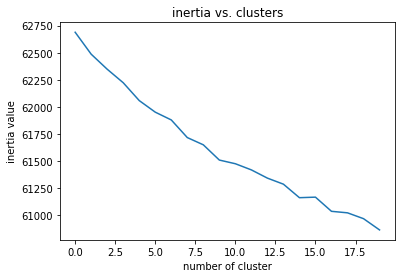

In [113]:
plt.plot(inertia_list_tf_idf)
plt.ylabel("inertia value")
plt.xlabel("number of cluster")
plt.title("inertia vs. clusters")
plt.show()

## Observation

Once again,knee shaped curve is not observed. Next, we will go upto k=40.

In [115]:
number_of_clusters = 20
print("Top terms per cluster:")
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
terms = tf_idf_vectorizer.get_feature_names()
for i in range(number_of_clusters):
    top_ten_words = [terms[ind] for ind in order_centroids[i, :5]]
    print("Cluster {}: {}".format(i, ' '.join(top_ten_words)))

Top terms per cluster:
Cluster 0: abort clinic abort foetus foetus ebola clinic
Cluster 1: health call drug children patient
Cluster 2: death death rate rate hospit death hospit
Cluster 3: help smoker quit quit help treat nh staff
Cluster 4: uk ebola uk ebola ebola nurs nurs
Cluster 5: risk test cancer blood test blood
Cluster 6: hospit warn incid patient trust
Cluster 7: ebola vaccin ebola vaccin ebola case leon
Cluster 8: care home care home social care social
Cluster 9: aamp wait aamp wait target wait time
Cluster 10: mental health mental health child mental child
Cluster 11: cancer breast cancer breast cancer drug drug
Cluster 12: hiv healthi men give gay
Cluster 13: born babi born babi first wombtranspl wombtranspl
Cluster 14: gp see gp see gp practic practic
Cluster 15: babi babi death threeperson threeperson babi death
Cluster 16: ban smoke car smoke ban car smoke
Cluster 17: nh nh staff staff strike plan
Cluster 18: face fund england nh nh england
Cluster 19: obes child obes ch

In [121]:
perc_reduction_tfidf = [] #Exploring percentage redution in inertia with increasing value of k
perc_reduction_tfidf.append(0)
for x in range(19):
    perc = round((inertia_list_tf_idf[x] - inertia_list_tf_idf[x+1])/inertia_list_tf_idf[x]*100,2)
    perc_reduction_tfidf.append(perc)
perc_reduction_tfidf

[0,
 0.32,
 0.22,
 0.2,
 0.27,
 0.17,
 0.12,
 0.26,
 0.11,
 0.23,
 0.06,
 0.09,
 0.12,
 0.09,
 0.2,
 -0.01,
 0.21,
 0.02,
 0.09,
 0.17]

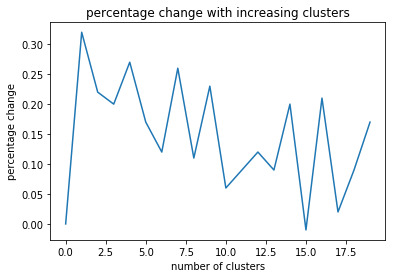

In [122]:
plt.plot(perc_reduction_tfidf)
plt.ylabel("percentage change")
plt.xlabel("number of clusters")
plt.title("percentage change with increasing clusters")
plt.show()

## Observation

This graph doesn't exhibit the regular behavior of global maxima for a value k and then stabilizing at a low value.But after k=10, there are instances where percentage change becomes negative for some values of k.

In [ ]:
for k in range (21, 41):
    km = KMeans(n_clusters=k, random_state=1).fit(tf_idf_tweet_matrix)
    labels = km.labels_
    inertia = km.inertia_
    inertia_list_tf_idf.append(inertia)
    print("k:",k, " cost:", inertia)

k: 21  cost: 60788.77019273202
k: 22  cost: 60808.002041529646
k: 23  cost: 60724.83768472077
k: 24  cost: 60696.28114463237
k: 25  cost: 60634.77576975134
k: 26  cost: 60605.836765526605
k: 27  cost: 60527.00553772657
k: 28  cost: 60488.45523806715
k: 29  cost: 60309.98172805119
k: 30  cost: 60334.36000131367
k: 31  cost: 60298.87050823702
k: 32  cost: 60301.875749876315
k: 33  cost: 60277.8919653372
k: 34  cost: 60193.11332324532


In [125]:
inertia_list_tf_idf = [round(val,0) for val in inertia_list_tf_idf]

In [128]:
perc_reduction_tfidf = []
perc_reduction_tfidf.append(0)
for x in range(39):
    perc = round((inertia_list_tf_idf[x] - inertia_list_tf_idf[x+1])/inertia_list_tf_idf[x]*100,2)
    perc_reduction_tfidf.append(perc)
#perc_reduction_tfidf

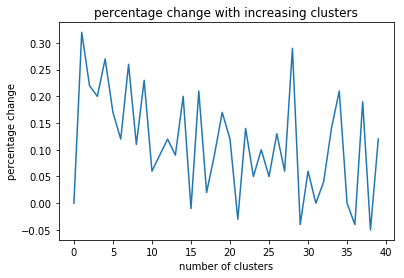

In [129]:
plt.plot(perc_reduction_tfidf)
plt.ylabel("percentage change")
plt.xlabel("number of clusters")
plt.title("percentage change with increasing clusters")
plt.show()

## Observation

This graph shows percentage change for values of k ranging from 1 to 40. Although there is no clear pattern,the curve has negative value at various point after k =10.

In [182]:
number_of_clusters = 40
print("Top terms per cluster:")
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
terms = tf_idf_vectorizer.get_feature_names()
for i in range(number_of_clusters):
    top_ten_words = [terms[ind] for ind in order_centroids[i, :5]]
    print("Cluster {}: {}".format(i, ' '.join(top_ten_words)))

Top terms per cluster:
Cluster 0: work cell bodi stem cell stem
Cluster 1: hospit death fail hospit death hospit care
Cluster 2: pledg push labour labour pledg miliband
Cluster 3: health help patient death gp
Cluster 4: case ebola case ebola us us ebola
Cluster 5: obes warn school child obes child
Cluster 6: trust nh trust nh hospit trust death
Cluster 7: children eat children hospit eat disord disord
Cluster 8: brain babi brain brain scan brain injuri scan
Cluster 9: babi babi death threeperson threeperson babi death
Cluster 10: die assist assist die assist suicid suicid
Cluster 11: ebola ebola outbreak leon outbreak sierra leon
Cluster 12: new nh new nh new patient new drug
Cluster 13: face fund bn nh england
Cluster 14: vaccin ebola vaccin ebola vaccin trial trial
Cluster 15: flu bird bird flu flu vaccin flu jab
Cluster 16: uk call ebola screen ebola screen
Cluster 17: delay hit benefit cancer patient cancer
Cluster 18: home care home care abus home abus
Cluster 19: life diabet may 

## Observation - Comparison between K=10 and K=40

Lets pickup some clusters from k=40 and see how they fit in under broader clusters of k=10.
1. Cluster 3 of k=10 broadly talks about cancer. Similarly, clusters 17,26,28 all talk about different subtopics within cancer.
2. Cluster 9 of k=10 talks about ebola. Similarly, clusters 4,11,14,16 are primarily related to ebola.
3. Cluster 4 of k=10 is focussed patient care and child care. Similarly, clusters 1,18,24 of k=40 highlight the same subject.

The observations above show that clusters of k=40 can be narrow down by a factor of 3 to 4. This means that if we acknowledge broader categories in the above observations as primary categories,the optimal value of k lies between 10 to 13 (i.e. 40/3>=x>=40/4).

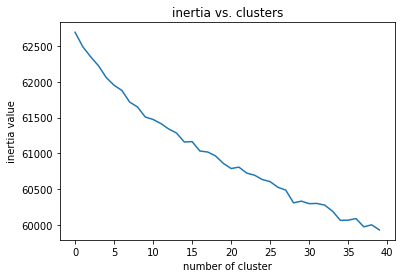

In [131]:
plt.plot(inertia_list_tf_idf)
plt.ylabel("inertia value")
plt.xlabel("number of cluster")
plt.title("inertia vs. clusters")
plt.show()

## Exploring optimal Sub-Topics based on 10 broad Topics

In this exercise, we split the dataset into 10 smaller datasets based on 10 clusters. Optimal value k is then explored in the range 1 to 20. Cluster centroids are printed where k is a multiple of 5. Again, inertia falls gradually and doesn't exhibit knee shaped curve. It is interesting to see that the optimal value of k is subjective and as the value of k increase, broader clusters get subdivided into smaller clusters that still make a lot of sense.

In [138]:
for i in range(10):
    category_df = df[df['category_tf_idf']==i]
    tf_idf_category_vectorizer = TfidfVectorizer(stop_words=stop_words_set,ngram_range=(1,2),max_df=.8)
    tf_idf_category_tweet_matrix = tf_idf_category_vectorizer.fit_transform(category_df['cleaned_tweet'])
    print("-"*100)
    print("Inertia variation for category: {}".format(i))
    for k in range (1,21):
        km = KMeans(n_clusters=k,random_state=1).fit(tf_idf_category_tweet_matrix)
        labels = km.labels_
        inertia = km.inertia_
        #inertia_list_tf_idf.append(inertia)
        print("k:",k, " cost:", inertia)
        if(k%5==0):
            number_of_clusters = k
            print("Top terms per cluster:")
            order_centroids = km.cluster_centers_.argsort()[:, ::-1]
            terms = tf_idf_category_vectorizer.get_feature_names()
            for i in range(number_of_clusters):
                top_ten_words = [terms[ind] for ind in order_centroids[i, :5]]
                print("Cluster {}: {}".format(i, ' '.join(top_ten_words)))

----------------------------------------------------------------------------------------------------
Inertia variation for category: 0
k: 1  cost: 36598.687481304805
k: 2  cost: 36515.31621771121
k: 3  cost: 36434.91615441003
k: 4  cost: 36352.118230891654
k: 5  cost: 36314.47345826386
Top terms per cluster:
Cluster 0: hospit death babi children help
Cluster 1: obes need women treatment child
Cluster 2: call ecigarett safeti inquiri antibiot
Cluster 3: care home care home hospit elderli
Cluster 4: link depress risk depress risk link heart
k: 6  cost: 36255.99089404039
k: 7  cost: 36190.203644164576
k: 8  cost: 36122.35648158372
k: 9  cost: 36067.121598208265
k: 10  cost: 36040.30221879024
Top terms per cluster:
Cluster 0: hospit obes assist stem cell stem
Cluster 1: death babi hospit death rate babi death
Cluster 2: care home care home elderli social care
Cluster 3: diseas heart diseas heart liver diseas liver
Cluster 4: risk peopl ambul infect heart
Cluster 5: test alzheim blood test 

## Observation

Observe how the broader topic of cancer gets subdivided into skin cancer, prostate cancer,breast cancer,lung cancer etc. for k=15 for category 3.

In [151]:
#Cleaning for latent semantic analysis
content_processed = []
for text in content_list_clean:
    text = decontracter(text)
    text = url_remover(text)
    text = escape_remover(text)
    text = text.lower()
    word_list = text.split()
    text = [spc_remover(word) for word in word_list]
    text = " ".join(text)
    tokens = word_tokenize(text)
    words = [word for word in tokens if word.isalpha()]
    words = [word for word in words if not word in stop_words_set]
    porter = PorterStemmer()
    stemmed = [porter.stem(word) for word in words]
    #text = " ".join(stemmed)
    content_processed.append(stemmed)

In [152]:
lsa_df = pd.DataFrame({"original_tweet":content_list_clean,
                   "cleaned_tweet":content_processed})
lsa_df.head()

,original_tweet,cleaned_tweet
0,Breast cancer risk test devised http://bbc.in/...,"[breast, cancer, risk, test, devis]"
1,GP workload harming care - BMA poll http://bbc...,"[gp, workload, harm, care, bma, poll]"
2,Short people's 'heart risk greater' http://bbc...,"[short, peopl, heart, risk, greater]"
3,New approach against HIV 'promising' http://bb...,"[new, approach, hiv, promis]"
4,Coalition 'undermined NHS' - doctors http://bb...,"[coalit, undermin, nh, doctor]"


# Latent Semantic Analysis

Latent Semantic Analysis is based on the principle of matrix decomposition.For instance,in SVD, a matrix can be decomposed into product of 3 matrices, the new dimension introduced gives information about classes in the data.In this section,we will explore two techniques namely latent semantic analysis and truncated svd.

In [183]:
#https://www.datacamp.com/community/tutorials/discovering-hidden-topics-python
def prepare_corpus(doc_clean):
    """
    Input  : clean document
    Purpose: create term dictionary of our courpus and Converting list of documents (corpus) into Document Term Matrix
    Output : term dictionary and Document Term Matrix
    """
    # Creating the term dictionary of our courpus, where every unique term is assigned an index. dictionary = corpora.Dictionary(doc_clean)
    dictionary = corpora.Dictionary(doc_clean)
    # Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
    doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]
    # generate LDA model
    return dictionary,doc_term_matrix

In [144]:
def create_gensim_lsa_model(doc_clean,number_of_topics,words):
    """
    Input  : clean document, number of topics and number of words associated with each topic
    Purpose: create LSA model using gensim
    Output : return LSA model
    """
    dictionary,doc_term_matrix=prepare_corpus(doc_clean)
    # generate LSA model
    lsamodel = LsiModel(doc_term_matrix, num_topics=number_of_topics, id2word = dictionary)  # train model
    print(lsamodel.print_topics(num_topics=number_of_topics, num_words=words))
    return lsamodel

In [154]:
def compute_coherence_values(dictionary, doc_term_matrix, doc_clean, stop, start=2, step=3):
    """
    Input   : dictionary : Gensim dictionary
              corpus : Gensim corpus
              texts : List of input texts
              stop : Max num of topics
    purpose : Compute c_v coherence for various number of topics
    Output  : model_list : List of LSA topic models
              coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, stop, step):
        # generate LSA model
        model = LsiModel(doc_term_matrix, num_topics=num_topics, id2word = dictionary)  # train model
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=doc_clean, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

In [146]:
def plot_graph(doc_clean,start, stop, step):
    dictionary,doc_term_matrix=prepare_corpus(doc_clean)
    model_list, coherence_values = compute_coherence_values(dictionary, doc_term_matrix,doc_clean,
                                                            stop, start, step)
    # Show graph
    x = range(start, stop, step)
    plt.plot(x, coherence_values)
    plt.xlabel("Number of Topics")
    plt.ylabel("Coherence score")
    plt.legend(("coherence_values"), loc='best')
    plt.show()

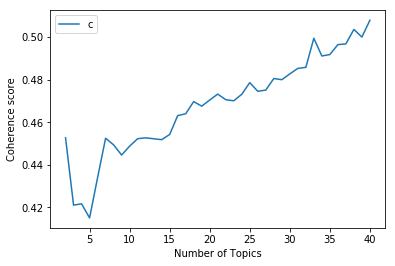

In [156]:
start,stop,step=2,41,1
plot_graph(lsa_df['cleaned_tweet'],start,stop,step)

## Observation

The coherence score doesn't show the behavior of local maxima and hence,this technique is not very good at separating the clusters. Looking at the highest magnitude words in each of the clusters below, same words like cancer,health and drug are present in multiple clusters.

In [158]:
# LSA Model
number_of_topics=10
words=10
#document_list,titles=load_data("","articles.txt")
#clean_text=preprocess_data(lsa_df['cleaned_tweet'])
model=create_gensim_lsa_model(lsa_df['cleaned_tweet'],number_of_topics,words)

[(0, '0.680*"ebola" + 0.602*"nh" + 0.132*"uk" + 0.117*"cancer" + 0.110*"health" + 0.101*"care" + 0.089*"patient" + 0.084*"new" + 0.080*"drug" + 0.073*"hospit"'), (1, '0.708*"nh" + -0.653*"ebola" + -0.113*"uk" + 0.077*"cancer" + 0.069*"care" + -0.059*"vaccin" + 0.048*"health" + -0.045*"case" + 0.042*"new" + -0.041*"leon"'), (2, '0.706*"health" + 0.409*"mental" + 0.279*"care" + -0.254*"nh" + 0.231*"cancer" + 0.156*"hospit" + -0.116*"ebola" + 0.104*"child" + 0.097*"patient" + 0.096*"cut"'), (3, '0.788*"cancer" + -0.370*"health" + -0.207*"mental" + 0.200*"hospit" + 0.180*"drug" + -0.145*"nh" + 0.115*"care" + 0.107*"breast" + 0.103*"patient" + 0.088*"test"'), (4, '-0.666*"care" + -0.469*"hospit" + 0.373*"cancer" + 0.238*"health" + -0.149*"patient" + -0.126*"home" + 0.120*"drug" + 0.118*"mental" + -0.115*"death" + -0.069*"fail"'), (5, '-0.698*"hospit" + 0.597*"care" + -0.237*"death" + -0.129*"patient" + 0.117*"home" + 0.101*"cancer" + -0.088*"aamp" + -0.067*"babi" + -0.055*"trust" + -0.050*"

In [193]:
out = filter(lambda x: x[1]>0,model.show_topic(1, topn=10))#checking topicwise top keywords
list(out)

[('nh', 0.7079796387365624),
 ('cancer', 0.07671594656028118),
 ('care', 0.06936144343488661),
 ('health', 0.04829801331735706),
 ('new', 0.04237854514238293)]

In [194]:
out = filter(lambda x: x[1]>0,model.show_topic(2, topn=10))
list(out)

[('health', 0.7058014022578121),
 ('mental', 0.4086035072526042),
 ('care', 0.2792059425675386),
 ('cancer', 0.23148000798401),
 ('hospit', 0.1556534219932951),
 ('child', 0.10374528592036775),
 ('patient', 0.0969355477875168),
 ('cut', 0.0964240141425931)]

In [195]:
out = filter(lambda x: x[1]>0,model.show_topic(3, topn=10))
list(out)

[('cancer', 0.7876744352338153),
 ('hospit', 0.2004315362506155),
 ('drug', 0.17987726976870683),
 ('care', 0.11513825326860981),
 ('breast', 0.10723673943758336),
 ('patient', 0.10252735283547115),
 ('test', 0.0880442562683091)]

In [196]:
out = filter(lambda x: x[1]>0,model.show_topic(4, topn=10))
list(out)

[('cancer', 0.37336924599932936),
 ('health', 0.23759525200536313),
 ('drug', 0.12020455847855215),
 ('mental', 0.11759692306918748)]

In [197]:
out = filter(lambda x: x[1]>0,model.show_topic(5, topn=10))
list(out)

[('care', 0.5969721809577879),
 ('home', 0.11670606464539628),
 ('cancer', 0.10063833346306254)]

# TF-IDF Vectorizer + Truncated SVD

Here we will model tf-idf vectorized tweets using truncated SVD.

In [161]:
content_processed = [] #Preprocessing
for text in content_list_clean:
    text = decontracter(text)
    text = url_remover(text)
    text = escape_remover(text)
    text = text.lower()
    word_list = text.split()
    text = [spc_remover(word) for word in word_list]
    text = " ".join(text)
    tokens = word_tokenize(text)
    words = [word for word in tokens if word.isalpha()]
    words = [word for word in words if not word in stop_words_set]
    porter = PorterStemmer()
    stemmed = [porter.stem(word) for word in words]
    text = " ".join(stemmed)
    content_processed.append(text)

In [162]:
svd_df = pd.DataFrame({"original_tweet":content_list_clean,
                   "cleaned_tweet":content_processed})
svd_df.head()

,original_tweet,cleaned_tweet
0,Breast cancer risk test devised http://bbc.in/...,breast cancer risk test devis
1,GP workload harming care - BMA poll http://bbc...,gp workload harm care bma poll
2,Short people's 'heart risk greater' http://bbc...,short peopl heart risk greater
3,New approach against HIV 'promising' http://bb...,new approach hiv promis
4,Coalition 'undermined NHS' - doctors http://bb...,coalit undermin nh doctor


In [166]:
tf_idf_svd_vectorizer = TfidfVectorizer(stop_words=stop_words_set,ngram_range=(1,2),max_df=.8)
tf_idf_svd_vectorizer.fit(svd_df['cleaned_tweet'])
tf_idf_svd_tweet_matrix = tf_idf_category_vectorizer.transform(svd_df['cleaned_tweet'])
tf_idf_svd_tweet_matrix.shape

(62864, 14322)

In [164]:
lsa = TruncatedSVD(n_components=10,n_iter=100)#experimenting with 10 clusters
lsa.fit(tf_idf_svd_tweet_matrix)

TruncatedSVD(algorithm='randomized', n_components=10, n_iter=100,
             random_state=None, tol=0.0)

In [168]:
lsa.components_.shape

(10, 14322)

In [167]:
terms = tf_idf_svd_vectorizer.get_feature_names()
for i,comp in enumerate(lsa.components_):
    term_in_comp = zip(terms,comp)
    sorted_terms = sorted(term_in_comp,key=lambda x: x[1],reverse=True)[:10]
    print("Topic: {}".format(i))
    for term in sorted_terms:
        print(term[0])
    print("-"*50)

Topic: 0
health
mental
mental health
ebola
nh
care
child
child mental
cut
servic
--------------------------------------------------
Topic: 1
ebola
uk
nh
vaccin
cancer
ebola vaccin
patient
drug
trial
case
--------------------------------------------------
Topic: 2
nh
cancer
care
hospit
patient
aamp
wait
drug
breast
breast cancer
--------------------------------------------------
Topic: 3
cancer
breast
breast cancer
drug
cancer drug
risk
death
test
link
hospit
--------------------------------------------------
Topic: 4
care
hospit
patient
home
death
care home
fail
aamp
elderli
babi
--------------------------------------------------
Topic: 5
aamp
wait
time
wait time
aamp wait
target
patient
miss
time target
target miss
--------------------------------------------------
Topic: 6
hospit
death
babi
trust
rate
hospit death
death rate
babi death
patient death
death inquiri
--------------------------------------------------
Topic: 7
vaccin
hospit
ebola vaccin
trial
vaccin trial
aamp
cancer
tria

## Observation

We can see that SVD hasn't been able to separate clusters as well as the KMeans. Topics like ebola,cancer and vaccination are spread over multiple topics.

# Word2Vec + KMeans

Here, we will convert every word to 300 dimensional vector and then take average of all the vectors in the tweet. The sentence average vectors are then passed modelled using KMeans clustering for different values of K.The inertia curve is smoother and clusters well separated. Since we have reduced the vector dimension from 14000 to 300, curse of dimensionality might have gone down.

In [200]:
w2v_model = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin',binary=True)
print(w2v_model.most_similar('ipl'))

[('India_vs_Srilanka', 0.6812533140182495), ('Ind_vs', 0.667962908744812), ('sachin', 0.6583624482154846), ('sachin_tendulkar', 0.6542117595672607), ('asia_cup', 0.6539091467857361), ('IPL_T##', 0.6497546434402466), ('odi', 0.6412261128425598), ('ind_vs', 0.6401765942573547), ('dravid', 0.6361685991287231), ('sehwag', 0.6241488456726074)]


In [211]:
#Google news word2vec doesn't work on stemmed words
content_processed = []
for text in content_list_clean:
    text = decontracter(text)
    text = url_remover(text)
    text = escape_remover(text)
    text = text.lower()
    word_list = text.split()
    text = [spc_remover(word) for word in word_list]
    text = " ".join(text)
    tokens = word_tokenize(text)
    words = [word for word in tokens if word.isalpha()]
    words = [word for word in words if not word in stop_words_set]
    #porter = PorterStemmer()
    #stemmed = [porter.stem(word) for word in words]
    #text = " ".join(stemmed)
    content_processed.append(words)

In [208]:
w2v_words = list(w2v_model.vocab)

In [210]:
len(w2v_words)

3000000

In [212]:
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in content_processed: # for each review/sentence
    sent_vec = np.zeros(300) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

62864
300


In [213]:
final_vector = np.asarray(sent_vectors)
print(type(final_vector))
print(final_vector.shape)

<class 'numpy.ndarray'>
(62864, 300)


In [214]:
number_of_clusters=10 #Randomly experimenting with 10 Clusters
km = KMeans(n_clusters=number_of_clusters)
km.fit(final_vector)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=10, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [221]:
print("Top terms per cluster:")
order_centroids = km.cluster_centers_
print(order_centroids.shape)
#terms = tf_idf_vectorizer.get_feature_names()
for i in range(number_of_clusters):
    print(w2v_model.similar_by_vector(order_centroids[i]))
    print("\n")

Top terms per cluster:
(10, 300)
[('Corneal_transplants', 0.7442001700401306), ('shunt_implanted', 0.7191455364227295), ('dialed_Ybarra', 0.7140657901763916), ('lion_Frese', 0.7031638622283936), ('transfusion_syndrome', 0.701056957244873), ('liver_regenerates', 0.6936143636703491), ('Clot_busting', 0.6899798512458801), ('unblock_clogged_arteries', 0.6892584562301636), ('immunological_reaction', 0.6887111663818359), ('invasive_biopsy', 0.686381995677948)]


[('McCargar_bribed', 0.7115593552589417), ('Ozone_disinfection_produces', 0.7099142670631409), ('Sororities_antics_spur', 0.7027449607849121), ('OTCBB_AJGH_leading', 0.7005481719970703), ('fizzy_citrus', 0.6996176242828369), ('chews_nicotine_gum', 0.6929302215576172), ('Boom_billows', 0.6852578520774841), ('AETD_VIP_abstain', 0.6803761720657349), ('Calorie_labeling', 0.6791009902954102), ('Maushart_admits', 0.6675135493278503)]


[('cancer', 0.8650716543197632), ('cancerdefine', 0.732646107673645), ('breast_cancer', 0.727159142494201

In [222]:
wv_df = pd.DataFrame({"original_tweet":content_list_clean,
                   "cleaned_tweet":content_processed,
                     "labels":km.labels_})
wv_df.head()

,original_tweet,cleaned_tweet,labels
0,Breast cancer risk test devised http://bbc.in/...,"[breast, cancer, risk, test, devised]",2
1,GP workload harming care - BMA poll http://bbc...,"[gp, workload, harming, care, bma, poll]",8
2,Short people's 'heart risk greater' http://bbc...,"[short, people, heart, risk, greater]",6
3,New approach against HIV 'promising' http://bb...,"[new, approach, hiv, promising]",6
4,Coalition 'undermined NHS' - doctors http://bb...,"[coalition, undermined, nhs, doctors]",9


In [223]:
wv_df[wv_df['labels']==0].head()

,original_tweet,cleaned_tweet,labels
23,Child heart surgery deaths 'halved' http://bbc...,"[child, heart, surgery, deaths, halved]",0
30,Blood test for Down's syndrome hailed http://b...,"[blood, test, syndrome, hailed]",0
47,VIDEO: Life-saving knitters http://bbc.in/1Eim...,"[lifesaving, knitters]",0
80,Angelina Jolie has ovaries removed http://bbc....,"[angelina, jolie, ovaries, removed]",0
101,'Ebola-proof' tablet device developed http://b...,"[ebolaproof, tablet, device, developed]",0


In [224]:
wv_df[wv_df['labels']==1].head()

,original_tweet,cleaned_tweet,labels
20,VIDEO: Why are we having less sex? http://bbc....,"[less, sex]",1
32,Paracetamol ‘no good for back pain' http://bbc...,"[paracetamol, good, back, pain]",1
82,Methadone programme 'a black hole' http://bbc....,"[methadone, programme, black, hole]",1
85,'Eat rice cold for fewer calories' http://bbc....,"[eat, rice, cold, fewer, calories]",1
103,VIDEO: Toxic smog prompts health warning http:...,"[toxic, smog, prompts, health, warning]",1


In [233]:
wv_df[wv_df['labels']==2].head()

,original_tweet,cleaned_tweet,labels
0,Breast cancer risk test devised http://bbc.in/...,"[breast, cancer, risk, test, devised]",2
15,VIDEO: Skin cancer spike 'from 60s holidays' h...,"[skin, cancer, spike, holidays]",2
17,Skin cancer 'linked to holiday boom' http://bb...,"[skin, cancer, linked, holiday, boom]",2
22,Personal cancer vaccines 'exciting' http://bbc...,"[personal, cancer, vaccines, exciting]",2
61,Fitness linked to lower cancer risk http://bbc...,"[fitness, linked, lower, cancer, risk]",2


In [234]:
wv_df[wv_df['labels']==3].head()

,original_tweet,cleaned_tweet,labels
16,"80,000 'might die' in future outbreak http://b...","[amight, die, future, outbreak]",3
43,VIDEO: Vaccine to protect from meningitis B ht...,"[vaccine, protect, meningitis, b]",3
44,Chikungunya revives herbal remedies in Antigua...,"[chikungunya, revives, herbal, remedies, antigua]",3
46,Meningitis B vaccine deal agreed http://bbc.in...,"[meningitis, b, vaccine, deal, agreed]",3
91,Disease-carrying mosquitoes warning http://bbc...,"[diseasecarrying, mosquitoes, warning]",3


In [229]:
inertia_list_w2v = []
for k in range (1, 41):
    km = KMeans(n_clusters=k, random_state=1).fit(final_vector)
    labels = km.labels_
    inertia = km.inertia_
    inertia_list_w2v.append(inertia)
    print("k:",k, " cost:", inertia)

k: 1  cost: 142129.20426391007
k: 2  cost: 137309.2832771931
k: 3  cost: 133384.4880280766
k: 4  cost: 130934.31749668145
k: 5  cost: 128819.47251019925
k: 6  cost: 127371.29999694033
k: 7  cost: 126103.04585529534
k: 8  cost: 124927.41806183165
k: 9  cost: 123952.46135626352
k: 10  cost: 122920.03900296472
k: 11  cost: 122010.83956993016
k: 12  cost: 121173.81762258265
k: 13  cost: 120516.47154996272
k: 14  cost: 119844.251306954
k: 15  cost: 119161.71712793138
k: 16  cost: 118611.17564353379
k: 17  cost: 117950.3936881178
k: 18  cost: 117546.2456605166
k: 19  cost: 117163.95253021366
k: 20  cost: 116497.01534106319
k: 21  cost: 116102.18997522516
k: 22  cost: 115766.84075486418
k: 23  cost: 115368.7114309396
k: 24  cost: 114990.6451631137
k: 25  cost: 114586.40226865016
k: 26  cost: 114248.53417493442
k: 27  cost: 114023.0599577704
k: 28  cost: 113505.46629693951
k: 29  cost: 113248.42399212986
k: 30  cost: 112937.32078582307
k: 31  cost: 112628.50010474722
k: 32  cost: 112458.736191

In [230]:
inertia_list_w2v = [round(val,0) for val in inertia_list_w2v]

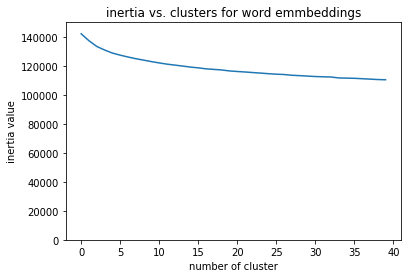

In [232]:
plt.plot(inertia_list_w2v)
plt.ylim((0,150000))
plt.ylabel("inertia value")
plt.xlabel("number of cluster")
plt.title("inertia vs. clusters for word emmbeddings")
plt.show()

# Observation

The curve shows similar behavior to other word vectorizations in Kmeans. But the curve is much smoother and clusters well separated.

In [303]:
from collections import Counter 
  
def most_frequent(List): 
    occurence_count = Counter(List) 
    sorted_x = sorted(occurence_count.items(), key=lambda kv: kv[1])
    final_x = [x[0] for x in sorted_x]
    return final_x

List = ['chikungunya', 'revives', 'herbal', 'remedies', 'antigua','revives', 'herbal','herbal']
print(most_frequent(List)[-3:])

['antigua', 'revives', 'herbal']


In [283]:
n_clusters = 10
print("Most frequent words")
for i in range(n_clusters):
    f_df = wv_df[wv_df['labels']==i]
    s_list = list(f_df['cleaned_tweet'])
    flat_list = []
    for sublist in s_list:
        for item in sublist:
            flat_list.append(item)
    print("-"*50)
    print("Cluster: {}".format(i))
    print(most_frequent(flat_list)[-5:])
    

Most frequent words
--------------------------------------------------
Cluster: 0
[('patient', 192), ('transplant', 304), ('heart', 432), ('brain', 608), ('surgery', 736)]
--------------------------------------------------
Cluster: 1
[('drugs', 288), ('drug', 288), ('alcohol', 320), ('smoking', 480), ('ban', 480)]
--------------------------------------------------
Cluster: 2
[('test', 256), ('disease', 288), ('drug', 304), ('breast', 416), ('cancer', 3264)]
--------------------------------------------------
Cluster: 3
[('polio', 256), ('virus', 384), ('ebola', 416), ('flu', 496), ('vaccine', 704)]
--------------------------------------------------
Cluster: 4
[('us', 240), ('nurse', 304), ('leone', 320), ('uk', 720), ('ebola', 5104)]
--------------------------------------------------
Cluster: 5
[('child', 320), ('deaths', 352), ('hospital', 416), ('baby', 640), ('death', 816)]
--------------------------------------------------
Cluster: 6
[('help', 288), ('call', 320), ('could', 352), ('

In [286]:
final_vector.shape

(62864, 300)

In [287]:
wv_df['word_vectors'] = sent_vectors

In [288]:
wv_df.head(1)

,original_tweet,cleaned_tweet,labels,word_vectors
0,Breast cancer risk test devised http://bbc.in/...,"[breast, cancer, risk, test, devised]",2,"[-0.083740234375, 0.18271484375, 0.09440917968..."


In [294]:
#Exploring sub-clusters/topics
for i in range(10):
    category_df = wv_df[wv_df['labels']==i]
    v_mat = list(category_df['word_vectors'])
    print(len(v_mat))
    print("-"*100)
    print("Inertia variation for category: {}".format(i))
    for k in range (1,21):
        km = KMeans(n_clusters=k,random_state=1).fit(v_mat)
        labels = km.labels_
        inertia = km.inertia_
        #inertia_list_tf_idf.append(inertia)
        print("k:",k, " cost:", inertia)
        if(k%5==0):
            number_of_clusters = k
            print("Top terms per cluster:")
            category_df['labels'] = labels
            for i in range(number_of_clusters):
                f_df = category_df[category_df['labels']==i]
                s_list = list(f_df['cleaned_tweet'])
                flat_list = []
                for sublist in s_list:
                    for item in sublist:
                        flat_list.append(item)
                print("-"*50)
                print("Cluster: {}".format(i))
                print(most_frequent(flat_list)[-5:])

5072
----------------------------------------------------------------------------------------------------
Inertia variation for category: 0
k: 1  cost: 11807.741590047746
k: 2  cost: 11317.68110270235
k: 3  cost: 10982.997596313764
k: 4  cost: 10751.383486839979
k: 5  cost: 10440.273813785036
Top terms per cluster:


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


--------------------------------------------------
Cluster: 0
[('injury', 48), ('scan', 48), ('baby', 48), ('sleep', 64), ('brain', 608)]
--------------------------------------------------
Cluster: 1
[('patient', 80), ('heart', 112), ('surgeon', 112), ('op', 112), ('surgery', 688)]
--------------------------------------------------
Cluster: 2
[('first', 112), ('sperm', 112), ('organ', 112), ('donor', 128), ('transplant', 304)]
--------------------------------------------------
Cluster: 3
[('therapy', 128), ('blood', 144), ('stroke', 160), ('test', 176), ('heart', 304)]
--------------------------------------------------
Cluster: 4
[('pain', 48), ('ears', 48), ('implant', 64), ('breast', 64), ('implants', 96)]
k: 6  cost: 10183.10502145476
k: 7  cost: 10217.033713293105
k: 8  cost: 9886.917064925754
k: 9  cost: 9793.470995613505
k: 10  cost: 9614.785176038835
Top terms per cluster:


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


--------------------------------------------------
Cluster: 0
[('boss', 16), ('jailed', 16), ('implant', 32), ('implants', 48), ('breast', 80)]
--------------------------------------------------
Cluster: 1
[('stroke', 80), ('patient', 96), ('heart', 112), ('patients', 112), ('therapy', 128)]
--------------------------------------------------
Cluster: 2
[('risk', 32), ('child', 48), ('babies', 48), ('baby', 64), ('kidney', 64)]
--------------------------------------------------
Cluster: 3
[('schumacher', 16), ('sedation', 16), ('areduced', 16)]
--------------------------------------------------
Cluster: 4
[('marrow', 32), ('organ', 64), ('donors', 80), ('sperm', 112), ('donor', 128)]
--------------------------------------------------
Cluster: 5
[('man', 48), ('liver', 48), ('surgeon', 64), ('heart', 80), ('surgery', 704)]
--------------------------------------------------
Cluster: 6
[('amputees', 48), ('prosthetic', 48), ('hand', 48), ('ears', 48), ('skin', 48)]
------------------------

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


--------------------------------------------------
Cluster: 0
[('damage', 16), ('resurgence', 16), ('wouldamaging', 16), ('swaddling', 32), ('hips', 32)]
--------------------------------------------------
Cluster: 1
[('ovaries', 32), ('babies', 32), ('fertility', 32), ('sperm', 64), ('baby', 64)]
--------------------------------------------------
Cluster: 2
[('surgeon', 32), ('scan', 32), ('ultrasound', 32), ('amputees', 48), ('surgeons', 64)]
--------------------------------------------------
Cluster: 3
[('infection', 48), ('risk', 96), ('heart', 128), ('blood', 144), ('test', 176)]
--------------------------------------------------
Cluster: 4
[('schumacher', 16), ('sedation', 16), ('areduced', 16)]
--------------------------------------------------
Cluster: 5
[('opens', 16), ('uk', 32), ('cosmetic', 48), ('plastic', 48), ('surgery', 128)]
--------------------------------------------------
Cluster: 6
[('grown', 32), ('organs', 48), ('skin', 64), ('body', 80), ('human', 80)]
----------

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


k: 2  cost: 9317.409504108831
k: 3  cost: 8927.634402811538
k: 4  cost: 8647.371573788676
k: 5  cost: 8490.477660005386
Top terms per cluster:


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


--------------------------------------------------
Cluster: 0
[('call', 64), ('banned', 80), ('car', 112), ('smoking', 256), ('ban', 400)]
--------------------------------------------------
Cluster: 1
[('health', 128), ('warning', 128), ('drinks', 160), ('sugar', 160), ('food', 192)]
--------------------------------------------------
Cluster: 2
[('pregnancy', 48), ('women', 48), ('drink', 48), ('breastfeeding', 48), ('pregnant', 64)]
--------------------------------------------------
Cluster: 3
[('warning', 96), ('pill', 96), ('drug', 272), ('drugs', 288), ('alcohol', 288)]
--------------------------------------------------
Cluster: 4
[('quit', 96), ('tobacco', 112), ('cigarette', 144), ('smokers', 176), ('smoking', 208)]
k: 6  cost: 8412.772790149142
k: 7  cost: 8208.592631978552
k: 8  cost: 8072.073255445328
k: 9  cost: 7978.627306111196
k: 10  cost: 7816.333591509224
Top terms per cluster:


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


--------------------------------------------------
Cluster: 0
[('hiv', 48), ('addicts', 48), ('cannabis', 80), ('drug', 176), ('drugs', 272)]
--------------------------------------------------
Cluster: 1
[('energy', 32), ('booze', 48), ('drink', 48), ('calories', 64), ('drinks', 80)]
--------------------------------------------------
Cluster: 2
[('packaging', 48), ('tobacco', 80), ('cigarettes', 80), ('smoking', 112), ('cigarette', 144)]
--------------------------------------------------
Cluster: 3
[('device', 32), ('pills', 32), ('exercise', 32), ('contraceptive', 48), ('pill', 112)]
--------------------------------------------------
Cluster: 4
[('warning', 64), ('risk', 64), ('children', 80), ('health', 128), ('food', 160)]
--------------------------------------------------
Cluster: 5
[('obesity', 32), ('smoke', 32), ('risks', 48), ('smokers', 64), ('smoking', 112)]
--------------------------------------------------
Cluster: 6
[('call', 64), ('banned', 80), ('car', 112), ('smoking', 

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


--------------------------------------------------
Cluster: 0
[('use', 32), ('weight', 32), ('health', 48), ('warning', 64), ('drug', 112)]
--------------------------------------------------
Cluster: 1
[('school', 48), ('ban', 48), ('health', 80), ('children', 80), ('food', 176)]
--------------------------------------------------
Cluster: 2
[('call', 48), ('ecigarette', 48), ('car', 112), ('smoking', 208), ('ban', 352)]
--------------------------------------------------
Cluster: 3
[('food', 16), ('worse', 32), ('intake', 48), ('cut', 64), ('sugar', 144)]
--------------------------------------------------
Cluster: 4
[('new', 48), ('help', 80), ('quit', 112), ('smokers', 192), ('smoking', 272)]
--------------------------------------------------
Cluster: 5
[('pain', 32), ('vitamin', 32), ('pills', 32), ('exercise', 32), ('pill', 96)]
--------------------------------------------------
Cluster: 6
[('rise', 48), ('drink', 48), ('drug', 80), ('warning', 80), ('alcohol', 304)]
----------------

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


--------------------------------------------------
Cluster: 0
[('prostitutes', 16), ('antihiv', 16), ('drugs', 16), ('use', 32), ('sex', 80)]
--------------------------------------------------
Cluster: 1
[('worse', 32), ('much', 32), ('intake', 48), ('cut', 64), ('sugar', 176)]
--------------------------------------------------
Cluster: 2
[('call', 64), ('banned', 64), ('car', 112), ('smoking', 272), ('ban', 432)]
--------------------------------------------------
Cluster: 3
[('paid', 16), ('breastfeed', 32), ('new', 32), ('pregnancy', 48), ('breastfeeding', 48)]
--------------------------------------------------
Cluster: 4
[('sales', 32), ('packaging', 48), ('cigarettes', 64), ('tobacco', 80), ('cigarette', 144)]
--------------------------------------------------
Cluster: 5
[('foetal', 32), ('medicine', 32), ('cravings', 32), ('drug', 48), ('alcohol', 208)]
--------------------------------------------------
Cluster: 6
[('fines', 16), ('free', 16), ('formula', 16), ('drinking', 32), ('

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


k: 6  cost: 5243.524710638432
k: 7  cost: 5248.345737791238
k: 8  cost: 5076.236539050182
k: 9  cost: 5011.1862337539715
k: 10  cost: 4928.372055128762
Top terms per cluster:


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


--------------------------------------------------
Cluster: 0
[('warning', 32), ('risk', 48), ('drug', 96), ('cancer', 384), ('breast', 400)]
--------------------------------------------------
Cluster: 1
[('misdiagnosed', 32), ('risk', 64), ('prostate', 64), ('skin', 112), ('cancer', 384)]
--------------------------------------------------
Cluster: 2
[('uk', 80), ('drugs', 112), ('nhs', 160), ('drug', 208), ('cancer', 736)]
--------------------------------------------------
Cluster: 3
[('quits', 16), ('director', 16), ('quit', 16), ('cancer', 48), ('scandal', 48)]
--------------------------------------------------
Cluster: 4
[('ptsd', 16), ('diagnosed', 16)]
--------------------------------------------------
Cluster: 5
[('test', 48), ('campaign', 48), ('get', 64), ('teen', 64), ('cancer', 1008)]
--------------------------------------------------
Cluster: 6
[('vaccine', 16), ('begins', 16), ('chemo', 32), ('cancer', 32), ('trial', 32)]
--------------------------------------------------


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


--------------------------------------------------
Cluster: 0
[('cuts', 32), ('poverty', 32), ('linked', 48), ('deaths', 80), ('cancer', 128)]
--------------------------------------------------
Cluster: 1
[('treatment', 32), ('care', 80), ('patients', 96), ('hospital', 96), ('cancer', 336)]
--------------------------------------------------
Cluster: 2
[('gp', 48), ('lung', 64), ('uk', 80), ('rates', 96), ('cancer', 320)]
--------------------------------------------------
Cluster: 3
[('beat', 16), ('bowel', 32), ('rare', 48), ('heart', 48), ('disease', 176)]
--------------------------------------------------
Cluster: 4
[('prostate', 32), ('new', 48), ('risk', 80), ('test', 128), ('cancer', 208)]
--------------------------------------------------
Cluster: 5
[('warning', 32), ('risk', 32), ('drug', 96), ('cancer', 352), ('breast', 368)]
--------------------------------------------------
Cluster: 6
[('nhs', 64), ('prostate', 64), ('diagnosis', 80), ('skin', 96), ('cancer', 928)]
----------

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


k: 2  cost: 6750.789928993143
k: 3  cost: 6448.22536270342
k: 4  cost: 6239.687172612797
k: 5  cost: 6050.083395781501
Top terms per cluster:


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


--------------------------------------------------
Cluster: 0
[('infection', 96), ('mers', 112), ('bird', 144), ('flu', 208), ('virus', 304)]
--------------------------------------------------
Cluster: 1
[('drug', 64), ('antibiotics', 80), ('jab', 112), ('vaccine', 144), ('flu', 176)]
--------------------------------------------------
Cluster: 2
[('fight', 48), ('deaths', 64), ('malaria', 112), ('measles', 176), ('polio', 240)]
--------------------------------------------------
Cluster: 3
[('toddlers', 48), ('flu', 112), ('trial', 144), ('ebola', 384), ('vaccine', 560)]
--------------------------------------------------
Cluster: 4
[('probe', 16), ('ongoing', 16), ('outbreak', 32), ('investigated', 32), ('salmonella', 80)]
k: 6  cost: 5927.135019724319
k: 7  cost: 5798.348574760267
k: 8  cost: 5728.2175073784165
k: 9  cost: 5626.871381153316
k: 10  cost: 5480.011276869883
Top terms per cluster:
--------------------------------------------------
Cluster: 0
[('anticancer', 16), ('laos', 1

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


k: 11  cost: 5413.055849012855
k: 12  cost: 5320.270567410874
k: 13  cost: 5221.844177926987
k: 14  cost: 5140.523142104987
k: 15  cost: 5105.881202814168
Top terms per cluster:
--------------------------------------------------
Cluster: 0
[('camel', 48), ('infection', 64), ('gut', 80), ('mers', 112), ('virus', 272)]
--------------------------------------------------
Cluster: 1
[('risk', 32), ('new', 32), ('threat', 48), ('bird', 144), ('flu', 272)]
--------------------------------------------------
Cluster: 2
[('begins', 48), ('vaccines', 48), ('trial', 144), ('vaccine', 336), ('ebola', 400)]
--------------------------------------------------
Cluster: 3
[('meningitis', 32), ('malaria', 32), ('toddlers', 48), ('flu', 112), ('vaccine', 224)]
--------------------------------------------------
Cluster: 4
[('call', 64), ('antibiotic', 64), ('flu', 80), ('jab', 80), ('vaccine', 144)]
--------------------------------------------------
Cluster: 5
[('school', 32), ('parents', 48), ('cases', 48

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


k: 16  cost: 4991.375185880308
k: 17  cost: 4951.553968046369
k: 18  cost: 4902.41257239241
k: 19  cost: 4801.577371634078
k: 20  cost: 4775.02318597667
Top terms per cluster:


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


--------------------------------------------------
Cluster: 0
[('hepatitis', 32), ('c', 32), ('camel', 48), ('mers', 112), ('virus', 112)]
--------------------------------------------------
Cluster: 1
[('uk', 16), ('trial', 16), ('start', 16), ('ebola', 32), ('vaccine', 32)]
--------------------------------------------------
Cluster: 2
[('antibiotics', 48), ('call', 64), ('vaccine', 96), ('jab', 112), ('flu', 192)]
--------------------------------------------------
Cluster: 3
[('hope', 16), ('b', 32), ('malaria', 32), ('meningitis', 48), ('vaccine', 144)]
--------------------------------------------------
Cluster: 4
[('mmr', 32), ('school', 32), ('parents', 48), ('cases', 48), ('measles', 144)]
--------------------------------------------------
Cluster: 5
[('warning', 32), ('new', 32), ('threat', 48), ('bird', 144), ('flu', 160)]
--------------------------------------------------
Cluster: 6
[('us', 48), ('infection', 48), ('disease', 48), ('hiv', 64), ('virus', 192)]
------------------

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


--------------------------------------------------
Cluster: 0
[('hiv', 112), ('patient', 112), ('nurse', 144), ('uk', 704), ('ebola', 896)]
--------------------------------------------------
Cluster: 1
[('screening', 128), ('crisis', 128), ('case', 144), ('us', 160), ('ebola', 1968)]
--------------------------------------------------
Cluster: 2
[('nigeria', 96), ('africa', 208), ('sierra', 240), ('leone', 240), ('ebola', 912)]
--------------------------------------------------
Cluster: 3
[('death', 48), ('guinea', 64), ('liberia', 112), ('outbreak', 208), ('ebola', 688)]
--------------------------------------------------
Cluster: 4
[('us', 48), ('declares', 64), ('emergency', 112), ('nurse', 112), ('ebola', 640)]
k: 6  cost: 7095.913091732553
k: 7  cost: 6996.711181482906
k: 8  cost: 6919.1353656236415
k: 9  cost: 6747.873465347363
k: 10  cost: 6757.0502151867895
Top terms per cluster:


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


--------------------------------------------------
Cluster: 0
[('us', 96), ('nhs', 112), ('staff', 112), ('nurse', 144), ('ebola', 912)]
--------------------------------------------------
Cluster: 1
[('curb', 16), ('capital', 32), ('virus', 32), ('ebola', 64), ('guinea', 80)]
--------------------------------------------------
Cluster: 2
[('us', 96), ('liberia', 112), ('case', 144), ('crisis', 192), ('ebola', 1824)]
--------------------------------------------------
Cluster: 3
[('obama', 32), ('us', 32), ('ebola', 48), ('fight', 48), ('hiv', 144)]
--------------------------------------------------
Cluster: 4
[('nigeria', 80), ('declares', 128), ('sierra', 240), ('leone', 256), ('ebola', 480)]
--------------------------------------------------
Cluster: 5
[('shuts', 16), ('borders', 16), ('curb', 16), ('spread', 80), ('ebola', 128)]
--------------------------------------------------
Cluster: 6
[('scrutiny', 32), ('uk', 64), ('heathrow', 64), ('screening', 192), ('ebola', 208)]
-----------

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


--------------------------------------------------
Cluster: 0
[('dies', 32), ('patient', 64), ('london', 80), ('british', 96), ('ebola', 224)]
--------------------------------------------------
Cluster: 1
[('global', 32), ('security', 32), ('obama', 48), ('world', 64), ('ebola', 288)]
--------------------------------------------------
Cluster: 2
[('team', 64), ('first', 96), ('us', 112), ('case', 128), ('ebola', 624)]
--------------------------------------------------
Cluster: 3
[('critical', 32), ('us', 32), ('healthcare', 48), ('nurse', 192), ('ebola', 320)]
--------------------------------------------------
Cluster: 4
[('declares', 48), ('lockdown', 64), ('sierra', 240), ('leone', 240), ('ebola', 240)]
--------------------------------------------------
Cluster: 5
[('w', 48), ('west', 80), ('nigeria', 80), ('africa', 224), ('ebola', 352)]
--------------------------------------------------
Cluster: 6
[('guinea', 32), ('summit', 32), ('declares', 80), ('ebola', 144), ('emergency', 160)

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


--------------------------------------------------
Cluster: 0
[('drastic', 16), ('action', 16), ('needed', 32), ('msf', 32), ('ebola', 80)]
--------------------------------------------------
Cluster: 1
[('many', 32), ('people', 32), ('children', 48), ('patients', 48), ('ebola', 272)]
--------------------------------------------------
Cluster: 2
[('results', 32), ('checks', 48), ('new', 48), ('test', 64), ('ebola', 192)]
--------------------------------------------------
Cluster: 3
[('virus', 16), ('battle', 32), ('capital', 32), ('guinea', 96), ('ebola', 112)]
--------------------------------------------------
Cluster: 4
[('join', 32), ('fight', 32), ('leone', 32), ('ebola', 368), ('uk', 384)]
--------------------------------------------------
Cluster: 5
[('sa', 16), ('flavoured', 16), ('condoms', 16), ('fight', 16), ('hiv', 112)]
--------------------------------------------------
Cluster: 6
[('worker', 48), ('vaccine', 48), ('nurse', 112), ('uk', 240), ('ebola', 288)]
----------------

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


--------------------------------------------------
Cluster: 0
[('born', 96), ('threeperson', 112), ('children', 208), ('babies', 224), ('baby', 352)]
--------------------------------------------------
Cluster: 1
[('girl', 144), ('dies', 144), ('man', 160), ('boy', 176), ('mother', 208)]
--------------------------------------------------
Cluster: 2
[('damages', 64), ('court', 64), ('legal', 64), ('abortion', 96), ('case', 112)]
--------------------------------------------------
Cluster: 3
[('trust', 112), ('baby', 160), ('hospital', 288), ('deaths', 352), ('death', 672)]
--------------------------------------------------
Cluster: 4
[('neglect', 64), ('child', 80), ('jailed', 80), ('doctor', 112), ('abuse', 144)]
k: 6  cost: 10004.486217209927
k: 7  cost: 9908.718759049452
k: 8  cost: 9711.181262513126
k: 9  cost: 9610.681669209784
k: 10  cost: 9536.003208998542
Top terms per cluster:


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


--------------------------------------------------
Cluster: 0
[('twin', 48), ('new', 80), ('born', 80), ('babies', 128), ('baby', 336)]
--------------------------------------------------
Cluster: 1
[('born', 16), ('miscarriages', 16), ('vote', 48), ('threeperson', 80), ('babies', 96)]
--------------------------------------------------
Cluster: 2
[('life', 32), ('disabled', 48), ('parents', 112), ('child', 144), ('children', 256)]
--------------------------------------------------
Cluster: 3
[('sperm', 64), ('mother', 80), ('boy', 96), ('girl', 112), ('man', 112)]
--------------------------------------------------
Cluster: 4
[('rate', 64), ('suicide', 80), ('child', 80), ('death', 160), ('deaths', 272)]
--------------------------------------------------
Cluster: 5
[('death', 64), ('nurse', 64), ('jailed', 80), ('doctor', 128), ('abuse', 128)]
--------------------------------------------------
Cluster: 6
[('coverup', 16), ('primodos', 16)]
------------------------------------------------

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


--------------------------------------------------
Cluster: 0
[('medical', 16), ('milestone', 16), ('man', 16), ('walks', 16)]
--------------------------------------------------
Cluster: 1
[('deaths', 80), ('care', 96), ('ambulance', 112), ('death', 224), ('hospital', 256)]
--------------------------------------------------
Cluster: 2
[('suicide', 80), ('child', 112), ('baby', 144), ('deaths', 272), ('death', 384)]
--------------------------------------------------
Cluster: 3
[('death', 32), ('nurse', 32), ('patient', 48), ('jailed', 64), ('doctor', 144)]
--------------------------------------------------
Cluster: 4
[('hate', 32), ('crimes', 32), ('child', 48), ('abuse', 48), ('life', 48)]
--------------------------------------------------
Cluster: 5
[('sons', 32), ('dad', 48), ('child', 80), ('mum', 80), ('mother', 160)]
--------------------------------------------------
Cluster: 6
[('anorexic', 16), ('daughter', 32), ('obese', 32), ('ashya', 32), ('parents', 64)]
--------------------

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


--------------------------------------------------
Cluster: 0
[('probe', 64), ('deaths', 80), ('patient', 96), ('death', 192), ('hospital', 240)]
--------------------------------------------------
Cluster: 1
[('struggle', 16), ('prisoners', 16), ('deaf', 32), ('parents', 96), ('children', 176)]
--------------------------------------------------
Cluster: 2
[('male', 16), ('found', 16), ('appeal', 16), ('boy', 32), ('donor', 32)]
--------------------------------------------------
Cluster: 3
[('backfired', 16), ('suffering', 16), ('silence', 16), ('assisted', 48), ('suicide', 48)]
--------------------------------------------------
Cluster: 4
[('childminder', 16), ('isacked', 16), ('fat', 16)]
--------------------------------------------------
Cluster: 5
[('cell', 48), ('ill', 64), ('girl', 80), ('boy', 80), ('mother', 112)]
--------------------------------------------------
Cluster: 6
[('baby', 32), ('five', 32), ('trust', 32), ('child', 64), ('deaths', 256)]
-----------------------------

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


--------------------------------------------------
Cluster: 0
[('us', 160), ('lives', 160), ('help', 176), ('people', 240), ('life', 272)]
--------------------------------------------------
Cluster: 1
[('concerns', 64), ('ecigarette', 64), ('action', 64), ('urged', 64), ('call', 160)]
--------------------------------------------------
Cluster: 2
[('time', 112), ('wait', 128), ('target', 176), ('waiting', 208), ('aampe', 304)]
--------------------------------------------------
Cluster: 3
[('drug', 128), ('could', 144), ('aampe', 160), ('test', 176), ('new', 336)]
--------------------------------------------------
Cluster: 4
[('pain', 96), ('could', 96), ('man', 112), ('loss', 112), ('body', 112)]
k: 6  cost: 23616.592643897337
k: 7  cost: 23420.38925672701
k: 8  cost: 23285.30077013744
k: 9  cost: 23140.649453164267
k: 10  cost: 23102.077021130823
Top terms per cluster:


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


--------------------------------------------------
Cluster: 0
[('scientists', 80), ('test', 96), ('aids', 96), ('hiv', 144), ('new', 288)]
--------------------------------------------------
Cluster: 1
[('close', 48), ('billion', 48), ('alzheimer', 80), ('one', 80), ('test', 80)]
--------------------------------------------------
Cluster: 2
[('dying', 80), ('men', 96), ('save', 96), ('lives', 96), ('man', 176)]
--------------------------------------------------
Cluster: 3
[('wait', 128), ('time', 128), ('target', 144), ('waiting', 192), ('aampe', 336)]
--------------------------------------------------
Cluster: 4
[('good', 112), ('us', 112), ('people', 112), ('help', 128), ('life', 192)]
--------------------------------------------------
Cluster: 5
[('public', 64), ('rise', 80), ('face', 80), ('food', 96), ('aampe', 96)]
--------------------------------------------------
Cluster: 6
[('review', 80), ('aampe', 80), ('pm', 96), ('action', 96), ('call', 192)]
-------------------------------

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


--------------------------------------------------
Cluster: 0
[('expansion', 32), ('chief', 32), ('health', 48), ('board', 48), ('ni', 64)]
--------------------------------------------------
Cluster: 1
[('pollution', 64), ('air', 64), ('high', 80), ('aampe', 80), ('cases', 96)]
--------------------------------------------------
Cluster: 2
[('work', 64), ('night', 80), ('body', 96), ('day', 112), ('pm', 144)]
--------------------------------------------------
Cluster: 3
[('right', 80), ('public', 96), ('get', 112), ('face', 128), ('aampe', 208)]
--------------------------------------------------
Cluster: 4
[('wikipedia', 16), ('say', 16), ('scientists', 16), ('ecigarettes', 16), ('phenomenon', 16)]
--------------------------------------------------
Cluster: 5
[('target', 128), ('wait', 128), ('time', 160), ('waiting', 208), ('aampe', 224)]
--------------------------------------------------
Cluster: 6
[('aids', 32), ('debate', 32), ('bill', 48), ('assisted', 112), ('dying', 128)]
-------

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


--------------------------------------------------
Cluster: 0
[('high', 64), ('getting', 64), ('cycling', 64), ('health', 80), ('pollution', 80)]
--------------------------------------------------
Cluster: 1
[('extra', 48), ('make', 64), ('fat', 64), ('food', 96), ('day', 112)]
--------------------------------------------------
Cluster: 2
[('ivf', 48), ('tooth', 64), ('decay', 64), ('people', 80), ('children', 176)]
--------------------------------------------------
Cluster: 3
[('seeing', 64), ('advice', 80), ('pressure', 80), ('pain', 96), ('right', 96)]
--------------------------------------------------
Cluster: 4
[('tooth', 32), ('sight', 32), ('makes', 32), ('ear', 32), ('cold', 48)]
--------------------------------------------------
Cluster: 5
[('change', 32), ('ecigarette', 32), ('new', 32), ('activity', 48), ('call', 224)]
--------------------------------------------------
Cluster: 6
[('helped', 32), ('million', 32), ('saved', 48), ('lives', 128), ('save', 144)]
----------------

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


--------------------------------------------------
Cluster: 0
[('statin', 64), ('asthma', 96), ('statins', 96), ('risk', 192), ('diabetes', 480)]
--------------------------------------------------
Cluster: 1
[('alzheimer', 160), ('link', 160), ('depression', 224), ('autism', 320), ('dementia', 576)]
--------------------------------------------------
Cluster: 2
[('schools', 32), ('childhood', 48), ('link', 64), ('child', 112), ('obesity', 720)]
--------------------------------------------------
Cluster: 3
[('amusical', 16), ('hallucination', 16)]
--------------------------------------------------
Cluster: 4
[('diets', 64), ('overweight', 64), ('healthy', 96), ('obese', 96), ('diet', 128)]
k: 6  cost: 10294.130881161538
k: 7  cost: 10166.414715149427
k: 8  cost: 9948.546824479252
k: 9  cost: 9906.679402403986
k: 10  cost: 9678.010599651925
Top terms per cluster:


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


--------------------------------------------------
Cluster: 0
[('schools', 32), ('childhood', 48), ('link', 64), ('child', 112), ('obesity', 688)]
--------------------------------------------------
Cluster: 1
[('doctors', 32), ('use', 32), ('statin', 64), ('asthma', 96), ('statins', 96)]
--------------------------------------------------
Cluster: 2
[('overweight', 64), ('children', 80), ('risk', 96), ('women', 128), ('obese', 160)]
--------------------------------------------------
Cluster: 3
[('patients', 48), ('risk', 48), ('alzheimer', 64), ('research', 64), ('dementia', 560)]
--------------------------------------------------
Cluster: 4
[('cbt', 32), ('schizophrenia', 80), ('alzheimer', 80), ('linked', 80), ('gene', 80)]
--------------------------------------------------
Cluster: 5
[('clues', 32), ('detectable', 32), ('first', 32), ('months', 32), ('autism', 320)]
--------------------------------------------------
Cluster: 6
[('amay', 32), ('help', 32), ('healthy', 80), ('vitamin',

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


--------------------------------------------------
Cluster: 0
[('research', 32), ('insight', 32), ('study', 32), ('dna', 48), ('alzheimer', 64)]
--------------------------------------------------
Cluster: 1
[('life', 32), ('centenarians', 32), ('children', 32), ('women', 64), ('obese', 160)]
--------------------------------------------------
Cluster: 2
[('schools', 32), ('childhood', 48), ('link', 64), ('child', 112), ('obesity', 624)]
--------------------------------------------------
Cluster: 3
[('research', 48), ('patients', 48), ('alzheimer', 64), ('schizophrenia', 64), ('dementia', 512)]
--------------------------------------------------
Cluster: 4
[('weight', 64), ('asthma', 80), ('disease', 80), ('risk', 96), ('diabetes', 432)]
--------------------------------------------------
Cluster: 5
[('obesity', 32), ('healthier', 32), ('healthy', 48), ('mediterranean', 48), ('diet', 128)]
--------------------------------------------------
Cluster: 6
[('doctors', 32), ('use', 32), ('thalid

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


k: 1  cost: 15531.138430820976
k: 2  cost: 14698.84132077713
k: 3  cost: 14154.949430634784
k: 4  cost: 13773.007973238828
k: 5  cost: 13453.182129482502
Top terms per cluster:


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


--------------------------------------------------
Cluster: 0
[('patient', 160), ('nhs', 176), ('aampe', 256), ('doctors', 304), ('patients', 512)]
--------------------------------------------------
Cluster: 1
[('call', 128), ('social', 128), ('elderly', 208), ('home', 320), ('care', 1824)]
--------------------------------------------------
Cluster: 2
[('aampe', 128), ('ambulance', 192), ('care', 208), ('hospitals', 416), ('hospital', 1520)]
--------------------------------------------------
Cluster: 3
[('risk', 80), ('cuts', 80), ('warning', 96), ('public', 144), ('health', 912)]
--------------------------------------------------
Cluster: 4
[('cuts', 96), ('care', 144), ('child', 176), ('health', 1280), ('mental', 1296)]
k: 6  cost: 13218.09095346867
k: 7  cost: 13034.62658516762
k: 8  cost: 12834.626505397582
k: 9  cost: 12748.940279277018
k: 10  cost: 12626.662980330033
Top terms per cluster:
--------------------------------------------------
Cluster: 0
[('board', 64), ('risk', 80),

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


k: 11  cost: 12591.60921627759
k: 12  cost: 12470.43671154518
k: 13  cost: 12376.653666554039
k: 14  cost: 12334.439759459014
k: 15  cost: 12218.930872088547
Top terms per cluster:


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


--------------------------------------------------
Cluster: 0
[('language', 32), ('hospital', 32), ('care', 32), ('visits', 48), ('checks', 128)]
--------------------------------------------------
Cluster: 1
[('strike', 64), ('aampe', 64), ('doctor', 96), ('medical', 160), ('doctors', 208)]
--------------------------------------------------
Cluster: 2
[('patients', 80), ('failing', 80), ('help', 80), ('elderly', 304), ('care', 304)]
--------------------------------------------------
Cluster: 3
[('cuts', 96), ('care', 144), ('child', 176), ('health', 1264), ('mental', 1296)]
--------------------------------------------------
Cluster: 4
[('hepatitis', 16), ('doctor', 32), ('psychiatric', 32), ('patients', 128), ('hospital', 128)]
--------------------------------------------------
Cluster: 5
[('inquiry', 48), ('home', 48), ('care', 64), ('hospital', 80), ('abuse', 192)]
--------------------------------------------------
Cluster: 6
[('food', 32), ('poverty', 32), ('dental', 32), ('warning'

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


k: 1  cost: 15787.115132198549
k: 2  cost: 15030.490708823236
k: 3  cost: 14675.407932205017
k: 4  cost: 14398.25353972609
k: 5  cost: 14182.199772729207
Top terms per cluster:
--------------------------------------------------
Cluster: 0
[('nhs', 80), ('wales', 96), ('hiv', 96), ('pfizer', 96), ('gps', 224)]
--------------------------------------------------
Cluster: 1
[('hours', 64), ('practices', 64), ('closure', 64), ('see', 64), ('gp', 688)]
--------------------------------------------------
Cluster: 2
[('health', 144), ('strike', 176), ('new', 224), ('staff', 240), ('nhs', 3920)]
--------------------------------------------------
Cluster: 3
[('india', 64), ('philippines', 64), ('eu', 96), ('doctors', 96), ('uk', 736)]
--------------------------------------------------
Cluster: 4
[('bn', 64), ('cameron', 80), ('aampe', 112), ('england', 384), ('nhs', 400)]


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


k: 6  cost: 14023.461969655733
k: 7  cost: 13817.703819226143
k: 8  cost: 13809.648710325024
k: 9  cost: 13583.62296841492
k: 10  cost: 13483.112629029278
Top terms per cluster:


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


--------------------------------------------------
Cluster: 0
[('jones', 48), ('welsh', 48), ('english', 64), ('cameron', 80), ('nhs', 464)]
--------------------------------------------------
Cluster: 1
[('ishocking', 16), ('outofhours', 32), ('failings', 32), ('care', 48), ('gp', 192)]
--------------------------------------------------
Cluster: 2
[('cash', 64), ('spending', 80), ('bn', 96), ('plan', 128), ('nhs', 1056)]
--------------------------------------------------
Cluster: 3
[('new', 48), ('astrazeneca', 64), ('bid', 64), ('eu', 96), ('pfizer', 128)]
--------------------------------------------------
Cluster: 4
[('tb', 64), ('rules', 64), ('nhs', 80), ('london', 80), ('hiv', 80)]
--------------------------------------------------
Cluster: 5
[('europe', 16), ('pharmacists', 32), ('see', 32), ('patients', 32), ('gps', 240)]
--------------------------------------------------
Cluster: 6
[('service', 48), ('hours', 64), ('practices', 64), ('closure', 64), ('gp', 496)]
---------------

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


--------------------------------------------------
Cluster: 0
[('end', 32), ('doctor', 48), ('doctors', 80), ('care', 80), ('nhs', 288)]
--------------------------------------------------
Cluster: 1
[('antibiotics', 16), ('pharmacists', 32), ('see', 32), ('patients', 32), ('gps', 240)]
--------------------------------------------------
Cluster: 2
[('scandal', 64), ('crisis', 64), ('debate', 80), ('health', 80), ('nhs', 304)]
--------------------------------------------------
Cluster: 3
[('fever', 32), ('worsen', 48), ('waits', 96), ('aampe', 112), ('england', 176)]
--------------------------------------------------
Cluster: 4
[('care', 48), ('new', 64), ('much', 64), ('data', 128), ('nhs', 1312)]
--------------------------------------------------
Cluster: 5
[('new', 80), ('complaints', 96), ('strike', 96), ('staff', 240), ('nhs', 704)]
--------------------------------------------------
Cluster: 6
[('improving', 32), ('palliative', 32), ('outofhours', 32), ('care', 80), ('gp', 80)]
----

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [302]:
topic_df = pd.DataFrame(columns=['Cluster','Topics','Sub-Topics'])

In [305]:
total_list = []
for i in range(10):
    out = most_freq_terms(wv_df,i)
    category_df = wv_df[wv_df['labels']==i]
    v_mat = list(category_df['word_vectors'])
    print(len(v_mat))
    print("-"*100)
    print("Inertia variation for category: {}".format(i))
    k=10
    km = KMeans(n_clusters=k,random_state=1).fit(v_mat)
    labels = km.labels_
    inertia = km.inertia_
    category_df['labels'] = labels
    for j in range(k):
        topic_list = []
        topic_list.append(i)
        topic_list.append(out)
        s_out = most_freq_terms(category_df,j)
        topic_list.append(s_out)
        total_list.append(topic_list)

--------------------------------------------------
Cluster: 0
['patient', 'transplant', 'heart', 'brain', 'surgery']
5072
----------------------------------------------------------------------------------------------------
Inertia variation for category: 0


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


--------------------------------------------------
Cluster: 0
['boss', 'jailed', 'implant', 'implants', 'breast']
--------------------------------------------------
Cluster: 0
['stroke', 'patient', 'heart', 'patients', 'therapy']
--------------------------------------------------
Cluster: 0
['risk', 'child', 'babies', 'baby', 'kidney']
--------------------------------------------------
Cluster: 0
['schumacher', 'sedation', 'areduced']
--------------------------------------------------
Cluster: 0
['marrow', 'organ', 'donors', 'sperm', 'donor']
--------------------------------------------------
Cluster: 0
['man', 'liver', 'surgeon', 'heart', 'surgery']
--------------------------------------------------
Cluster: 0
['amputees', 'prosthetic', 'hand', 'ears', 'skin']
--------------------------------------------------
Cluster: 0
['child', 'lung', 'urged', 'first', 'transplant']
--------------------------------------------------
Cluster: 0
['scan', 'sleep', 'baby', 'cells', 'brain']
----------

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


--------------------------------------------------
Cluster: 1
['hiv', 'addicts', 'cannabis', 'drug', 'drugs']
--------------------------------------------------
Cluster: 1
['energy', 'booze', 'drink', 'calories', 'drinks']
--------------------------------------------------
Cluster: 1
['packaging', 'tobacco', 'cigarettes', 'smoking', 'cigarette']
--------------------------------------------------
Cluster: 1
['device', 'pills', 'exercise', 'contraceptive', 'pill']
--------------------------------------------------
Cluster: 1
['warning', 'risk', 'children', 'health', 'food']
--------------------------------------------------
Cluster: 1
['obesity', 'smoke', 'risks', 'smokers', 'smoking']
--------------------------------------------------
Cluster: 1
['call', 'banned', 'car', 'smoking', 'ban']
--------------------------------------------------
Cluster: 1
['salt', 'worse', 'intake', 'cut', 'sugar']
--------------------------------------------------
Cluster: 1
['drink', 'drinking', 'drug', 'wa

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


--------------------------------------------------
Cluster: 2
['warning', 'risk', 'drug', 'cancer', 'breast']
--------------------------------------------------
Cluster: 2
['misdiagnosed', 'risk', 'prostate', 'skin', 'cancer']
--------------------------------------------------
Cluster: 2
['uk', 'drugs', 'nhs', 'drug', 'cancer']
--------------------------------------------------
Cluster: 2
['quits', 'director', 'quit', 'cancer', 'scandal']
--------------------------------------------------
Cluster: 2
['ptsd', 'diagnosed']
--------------------------------------------------
Cluster: 2
['test', 'campaign', 'get', 'teen', 'cancer']
--------------------------------------------------
Cluster: 2
['vaccine', 'begins', 'chemo', 'cancer', 'trial']
--------------------------------------------------
Cluster: 2
['blood', 'bowel', 'test', 'cancer', 'disease']
--------------------------------------------------
Cluster: 2
['lung', 'rates', 'survival', 'linked', 'cancer']
-------------------------------

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


--------------------------------------------------
Cluster: 3
['anticancer', 'laos', 'hope', 'malaria', 'vaccine']
--------------------------------------------------
Cluster: 3
['antibiotic', 'antibiotics', 'flu', 'jab', 'vaccine']
--------------------------------------------------
Cluster: 3
['gut', 'camel', 'mers', 'infection', 'virus']
--------------------------------------------------
Cluster: 3
['begins', 'vaccines', 'trial', 'vaccine', 'ebola']
--------------------------------------------------
Cluster: 3
['outbreak', 'dengue', 'bird', 'virus', 'flu']
--------------------------------------------------
Cluster: 3
['immune', 'children', 'fight', 'aid', 'malaria']
--------------------------------------------------
Cluster: 3
['offered', 'meningitis', 'toddlers', 'vaccine', 'flu']
--------------------------------------------------
Cluster: 3
['probe', 'ongoing', 'outbreak', 'investigated', 'salmonella']
--------------------------------------------------
Cluster: 3
['school', 'outbrea

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


--------------------------------------------------
Cluster: 4
['us', 'nhs', 'staff', 'nurse', 'ebola']
--------------------------------------------------
Cluster: 4
['curb', 'capital', 'virus', 'ebola', 'guinea']
--------------------------------------------------
Cluster: 4
['us', 'liberia', 'case', 'crisis', 'ebola']
--------------------------------------------------
Cluster: 4
['obama', 'us', 'ebola', 'fight', 'hiv']
--------------------------------------------------
Cluster: 4
['nigeria', 'declares', 'sierra', 'leone', 'ebola']
--------------------------------------------------
Cluster: 4
['shuts', 'borders', 'curb', 'spread', 'ebola']
--------------------------------------------------
Cluster: 4
['scrutiny', 'uk', 'heathrow', 'screening', 'ebola']
--------------------------------------------------
Cluster: 4
['pass', 'catch', 'liberia', 'outbreak', 'ebola']
--------------------------------------------------
Cluster: 4
['british', 'patient', 'nurse', 'uk', 'ebola']
-----------------

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


--------------------------------------------------
Cluster: 5
['twin', 'new', 'born', 'babies', 'baby']
--------------------------------------------------
Cluster: 5
['born', 'miscarriages', 'vote', 'threeperson', 'babies']
--------------------------------------------------
Cluster: 5
['life', 'disabled', 'parents', 'child', 'children']
--------------------------------------------------
Cluster: 5
['sperm', 'mother', 'boy', 'girl', 'man']
--------------------------------------------------
Cluster: 5
['rate', 'suicide', 'child', 'death', 'deaths']
--------------------------------------------------
Cluster: 5
['death', 'nurse', 'jailed', 'doctor', 'abuse']
--------------------------------------------------
Cluster: 5
['coverup', 'primodos']
--------------------------------------------------
Cluster: 5
['family', 'feed', 'baby', 'hospital', 'death']
--------------------------------------------------
Cluster: 5
['victims', 'legal', 'court', 'abortion', 'case']
-----------------------------

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


--------------------------------------------------
Cluster: 6
['scientists', 'test', 'aids', 'hiv', 'new']
--------------------------------------------------
Cluster: 6
['close', 'billion', 'alzheimer', 'one', 'test']
--------------------------------------------------
Cluster: 6
['dying', 'men', 'save', 'lives', 'man']
--------------------------------------------------
Cluster: 6
['wait', 'time', 'target', 'waiting', 'aampe']
--------------------------------------------------
Cluster: 6
['good', 'us', 'people', 'help', 'life']
--------------------------------------------------
Cluster: 6
['public', 'rise', 'face', 'food', 'aampe']
--------------------------------------------------
Cluster: 6
['review', 'aampe', 'pm', 'action', 'call']
--------------------------------------------------
Cluster: 6
['seeing', 'decay', 'eye', 'teeth', 'tooth']
--------------------------------------------------
Cluster: 6
['ecigarettes', 'phenomenon']
--------------------------------------------------
Clust

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


--------------------------------------------------
Cluster: 7
['schools', 'childhood', 'link', 'child', 'obesity']
--------------------------------------------------
Cluster: 7
['doctors', 'use', 'statin', 'asthma', 'statins']
--------------------------------------------------
Cluster: 7
['overweight', 'children', 'risk', 'women', 'obese']
--------------------------------------------------
Cluster: 7
['patients', 'risk', 'alzheimer', 'research', 'dementia']
--------------------------------------------------
Cluster: 7
['cbt', 'schizophrenia', 'alzheimer', 'linked', 'gene']
--------------------------------------------------
Cluster: 7
['clues', 'detectable', 'first', 'months', 'autism']
--------------------------------------------------
Cluster: 7
['amay', 'help', 'healthy', 'vitamin', 'diet']
--------------------------------------------------
Cluster: 7
['cusp', 'surgery', 'weight', 'risk', 'diabetes']
--------------------------------------------------
Cluster: 7
['heart', 'link', 'eat

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


--------------------------------------------------
Cluster: 8
['board', 'risk', 'warning', 'public', 'health']
--------------------------------------------------
Cluster: 8
['staff', 'hours', 'aampe', 'ambulances', 'ambulance']
--------------------------------------------------
Cluster: 8
['help', 'social', 'elderly', 'home', 'care']
--------------------------------------------------
Cluster: 8
['aampe', 'patient', 'doctor', 'medical', 'doctors']
--------------------------------------------------
Cluster: 8
['spending', 'strike', 'cuts', 'nhs', 'health']
--------------------------------------------------
Cluster: 8
['patient', 'care', 'aampe', 'hospital', 'patients']
--------------------------------------------------
Cluster: 8
['declare', 'publish', 'levels', 'aampe', 'hospitals']
--------------------------------------------------
Cluster: 8
['hospitals', 'elderly', 'endoflife', 'call', 'care']
--------------------------------------------------
Cluster: 8
['staff', 'savile', 'trust', 

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [306]:
len(total_list)

100

In [307]:
topic_df = pd.DataFrame(total_list,columns=['Cluster','Topics','Sub-Topics'])

# Topics and Sub-Topics

In the table below, we have 10 main topics and 10 sub-topics for each topic.Notice how Topic 1 which focusses on substance abuse and unhealthy food consumption gets further broken down into topics like smoking,salt/sugar intake,energy drinks,quitting drugs etc.Similarly cluster 7 which is focussed on patient and hospital care gets broken down into elderly/end-of-life care,ambulance and public health.

In [308]:
topic_df

,Cluster,Topics,Sub-Topics
0,0,"[patient, transplant, heart, brain, surgery]","[boss, jailed, implant, implants, breast]"
1,0,"[patient, transplant, heart, brain, surgery]","[stroke, patient, heart, patients, therapy]"
2,0,"[patient, transplant, heart, brain, surgery]","[risk, child, babies, baby, kidney]"
3,0,"[patient, transplant, heart, brain, surgery]","[schumacher, sedation, areduced]"
4,0,"[patient, transplant, heart, brain, surgery]","[marrow, organ, donors, sperm, donor]"
5,0,"[patient, transplant, heart, brain, surgery]","[man, liver, surgeon, heart, surgery]"
6,0,"[patient, transplant, heart, brain, surgery]","[amputees, prosthetic, hand, ears, skin]"
7,0,"[patient, transplant, heart, brain, surgery]","[child, lung, urged, first, transplant]"
8,0,"[patient, transplant, heart, brain, surgery]","[scan, sleep, baby, cells, brain]"
9,0,"[patient, transplant, heart, brain, surgery]","[stroke, risk, blood, test, heart]"


In [304]:
def most_freq_terms(category_df,cluster_number):
    f_df = category_df[category_df['labels']==cluster_number]
    s_list = list(f_df['cleaned_tweet'])
    flat_list = []
    for sublist in s_list:
        for item in sublist:
            flat_list.append(item)
    print("-"*50)
    print("Cluster: {}".format(i))
    print(most_frequent(flat_list)[-5:])
    return most_frequent(flat_list)[-5:]

In [296]:
from sklearn.cluster import AgglomerativeClustering

# Word2Vec + Agglomerative Clustering

Here we explore agglomerative clustering which assumes each point to be a separate cluster initially and then works on consolidating the points together based on specified similarity measure.

In [299]:
clustering = AgglomerativeClustering(affinity='euclidean',n_clusters=10,linkage="ward").fit(final_vector)

In [309]:
ag_df = pd.DataFrame({"original_tweet":content_list_clean,
                   "cleaned_tweet":content_processed,
                     "labels":clustering.labels_})
ag_df.head()

,original_tweet,cleaned_tweet,labels
0,Breast cancer risk test devised http://bbc.in/...,"[breast, cancer, risk, test, devised]",1
1,GP workload harming care - BMA poll http://bbc...,"[gp, workload, harming, care, bma, poll]",4
2,Short people's 'heart risk greater' http://bbc...,"[short, people, heart, risk, greater]",6
3,New approach against HIV 'promising' http://bb...,"[new, approach, hiv, promising]",6
4,Coalition 'undermined NHS' - doctors http://bb...,"[coalition, undermined, nhs, doctors]",3


In [310]:
for i in range(10):
    most_freq_terms(ag_df,i)

--------------------------------------------------
Cluster: 0
['ban', 'drugs', 'smoking', 'drug', 'obesity']
--------------------------------------------------
Cluster: 1
['diabetes', 'breast', 'risk', 'dementia', 'cancer']
--------------------------------------------------
Cluster: 2
['virus', 'polio', 'flu', 'ebola', 'vaccine']
--------------------------------------------------
Cluster: 3
['aampe', 'patients', 'nhs', 'hospital', 'care']
--------------------------------------------------
Cluster: 4
['care', 'new', 'uk', 'gp', 'nhs']
--------------------------------------------------
Cluster: 5
['abuse', 'hospital', 'baby', 'deaths', 'death']
--------------------------------------------------
Cluster: 6
['new', 'blood', 'heart', 'surgery', 'brain']
--------------------------------------------------
Cluster: 7
['case', 'leone', 'nurse', 'uk', 'ebola']
--------------------------------------------------
Cluster: 8
['warning', 'waiting', 'aampe', 'nhs', 'health']
--------------------------

## Observation

The clustering here hasn't performed as well as KMeans. We can observe that words like health and hospital are top words in multiple clusters.

# Conclusion

Clustering is subjective to human perception of clusters. Nevertheless, choosing the right clustering techniques and parmeters can help us match perceived clusters with mathematical clusters. We explored various techniques here and observed that KMeans with word2vec has superior performance compared to other techniques.